In [1]:
import numpy as np
import numpy.random as rand
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from pyDOE import *
from scipy.stats.distributions import norm

# #Datos de parámetros ajustados
parametros = [0.95,0.02,0.03,33.29845464,106.841154,-41.99886098,2.929335492,129.8723981,31.56238555,-114.5915881,89.6820252,-10031.64272,-31942.74221,11634.11783,-1268.507618,-38433.55757,-9537.321131,34251.76713,-26589.14422,0.482538159,0.000127782,0.002540203,10.615]

# Parametros del funcional
c=9.91E-17
d=2.31

#Datos del caso de estudio
V = 1728 #volumen
m_levadura = 1809 #Cantidad de levadura (kg)
m_sustrato = 14.6 #Cantidad de sustrato
c_levadura = (m_levadura/V)*10 #Concentracion de levadura (g/l)
c_sustrato = (m_sustrato)*10 #Concentracion de sustrato(g/l)

#Condiciones iniciales del modelo
Ce0=0.0 #Concentracion de producto en el tiempo t=0 (g/L)
Cdy0=0.0 #Concentracion de diacetilo en el tiempo t=0 (ppm)
Cea0=0.0 #Concentracion de etil acetato en el tiempo t=0 (ppm)
y0= [c_levadura, c_sustrato, Ce0, Cdy0, Cea0] #condiciones
x_inco0= y0[0] #Concentracion de levadura en el tiempo t=0 (g/L)
Cs0=y0[1] #Concentracion de sustrato en el tiempo t=0 (g/L)
x_lag0= parametros[0]*x_inco0 #Concentracion de levadura latente en el tiempo t=0 (g/L)
x_act0= parametros[1]*x_inco0 #Concentracion de levadura activa en el tiempo t=0 (g/L)
x_dead0= parametros[2]*x_inco0 #Concentracion de levadura muerta en el tiempo t=0 (g/L)
x_susp0= x_inco0 #Concentracion de levadura suspendida en el tiempo t=0 (g/L)
Uab= parametros[21] #(L/gh)
Udy=parametros[20] #(L/gh)
t_latencia= parametros[22] #tiempo de latencia

y0 = [x_lag0, x_act0, x_dead0, x_susp0, Cs0, Ce0, Cea0,Cdy0]

print(y0)

Temp = [10.5, 5.5, 3.7, 4.4, 6.0, 15.0]
Param=Temp

t0=0.0
tf=140.0

[9.9453125, 0.209375, 0.31406249999999997, 10.46875, 146.0, 0.0, 0.0, 0.0]


In [2]:
def TemperaturaRecetaIdeal(t,Temp):
    Param = Temp
    if t < 60.: T_ideal = Param[0] + 273.15# + (rand.rand() - 0.5) # T init, K
    elif t < 72.: T_ideal = 0.0833*t + Param[1] + 273.15# + (rand.rand() - 0.5) # K
    elif t < 84.: T_ideal = 0.1083*t + Param[2] + 273.15# + (rand.rand() - 0.5) # K
    elif t < 96.: T_ideal = 0.1*t + Param[3] + 273.15# + (rand.rand() - 0.5)
    elif t < 108.: T_ideal = 0.0833*t + Param[4] + 273.15# + (rand.rand() - 0.5)
    else: T_ideal = Param[5] + 273.15# + (rand.rand() - 0.5)
    return T_ideal

def TemperaturaRecetaIdealVec(t_eval,Temp):
    T_ideal = np.empty(t_eval.shape)
    T_ideal[t_eval<60.] = Temp[0] + 273.15
    T_ideal[(t_eval>=60.) & (t_eval<72.)] = 0.0833*t_eval[(t_eval>=60.) & (t_eval<72.)] + Temp[1] + 273.15
    T_ideal[(t_eval>=72.) & (t_eval<84.)] = 0.1083*t_eval[(t_eval>=72.) & (t_eval<84.)] + Temp[2] + 273.15
    T_ideal[(t_eval>=84.) & (t_eval<96.)] = 0.1*t_eval[(t_eval>=84.) & (t_eval<96.)] + Temp[3] + 273.15
    T_ideal[(t_eval>=96.) & (t_eval<108.)] = 0.0833*t_eval[(t_eval>=96.) & (t_eval<108.)] + Temp[4] + 273.15
    T_ideal[t_eval>=108.] = Temp[5] + 273.15
    return T_ideal


def fermentation(t,C,Param):
    temperatura = TemperaturaRecetaIdeal(t,Param)
    # T_tot.append(temperatura)    
    Usdo = np.exp(float(parametros[3] + (parametros[11]/temperatura))) #velocidad maxima de asentamiento de muerte celular
    Uxo = np.exp(float(parametros[4] + (parametros[12]/temperatura)))
    Uso = np.exp(float(parametros[5] + (parametros[13]/temperatura)))
    Ueo = np.exp(float(parametros[6] + (parametros[14]/temperatura)))
    Udt = np.exp(float(parametros[7] + (parametros[15]/temperatura))) #velocidad especifica de muerte celular
    Ul = np.exp(float(parametros[8] + (parametros[16]/temperatura))) #velocidad especifica de activacion celular
    ke = np.exp(float(parametros[9] + (parametros[17]/temperatura))) #cte de afinidad
    ks = ke #cte de afinidad
    Yea = np.exp(float(parametros[10] + (parametros[18]/temperatura))) #factor estequiometrico de la producción de etil acetato
    kx = parametros[19]*Cs0 #cte de afinidad de la biomasa

    Xlat, Xact, Xdead, Xsus, Cs, Ce, Cea, Cdy = C
    Usd = (Usdo*parametros[19]*Cs0)/(parametros[19]*Cs0 + Ce) #velocidad de asentamiento de muerte celular
    Ux = (Uxo*Cs)/(kx + Ce) #velocidad de crecimiento celular
    Us = (Uso*Cs)/(ks + Cs) #velocidad de consumo de azucar
    Ue = (Ueo*Cs)/(ke + Cs) #velocidad de produccion de etanol
    f = 1 - (Ce/(parametros[19]*Cs0)) #factor de inhibicion
    
    dXlatdt = -Ul*Xlat
    
    if t < t_latencia:
        dXactdt = Ul*Xlat
        dXdeaddt = -Usd*Xdead 
        dXsusdt = -Usd*Xdead
    else:
        dXactdt = Ux*Xact -Udt*Xact + Ul*Xlat
        dXdeaddt = -Usd*Xdead + Udt*Xact
        dXsusdt = Ux*Xact - Usd*Xdead
        
    dCsdt = -Us*Xact
    dCedt = f*Ue*Xact
    dCeadt = Yea*Ux*Xact
    dCdydt = Udy*Cs*Xact - Uab*Cdy*Ce
    
    return [dXlatdt, dXactdt, dXdeaddt, dXsusdt, dCsdt, dCedt, dCeadt, dCdydt]

In [3]:
def NuevaTemperatura(t,t_eval,Param2):
    Time = t_eval
    Temp = Param2
    for i in range(len(Time)-1):
        m = (Temp[i+1]-Temp[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = Temp[i]
        if ((t >= Time[i]) & (t < Time[i+1])): NT_ideal = m*t -m*x1+y1
    if(t >= Time[len(Time)-1]): NT_ideal = Temp[len(Temp)-1]
    return NT_ideal

def NuevaTemperaturaVec(t,t_eval,Param2):
    Time=t_eval
    Temp=Param2
    NT_ideal = np.empty(t.shape)
    for i in range(len(Time)-1):
        NT_ideal[(t_eval>=Time[i]) & (t_eval<Time[i+1])] = (Temp[i+1]-Temp[i])/(Time[i+1]-Time[i])*(t_eval[(t_eval>=Time[i]) & (t_eval<Time[i+1])]-Time[i]) + Temp[i]
    NT_ideal[t_eval>=Time[len(Time)-1]] = Temp[len(Temp)-1]
    return NT_ideal

def Newfermentation(t,C,Param1,Param2):
    temperatura = NuevaTemperatura(t,Param1,Param2)
    # T_tot.append(temperatura)    
    Usdo = np.exp(float(parametros[3] + (parametros[11]/temperatura))) #velocidad maxima de asentamiento de muerte celular
    Uxo = np.exp(float(parametros[4] + (parametros[12]/temperatura)))
    Uso = np.exp(float(parametros[5] + (parametros[13]/temperatura)))
    Ueo = np.exp(float(parametros[6] + (parametros[14]/temperatura)))
    Udt = np.exp(float(parametros[7] + (parametros[15]/temperatura))) #velocidad especifica de muerte celular
    Ul = np.exp(float(parametros[8] + (parametros[16]/temperatura))) #velocidad especifica de activacion celular
    ke = np.exp(float(parametros[9] + (parametros[17]/temperatura))) #cte de afinidad
    ks = ke #cte de afinidad
    Yea = np.exp(float(parametros[10] + (parametros[18]/temperatura))) #factor estequiometrico de la producción de etil acetato
    kx = parametros[19]*Cs0 #cte de afinidad de la biomasa

    Xlat, Xact, Xdead, Xsus, Cs, Ce, Cea, Cdy = C
    Usd = (Usdo*parametros[19]*Cs0)/(parametros[19]*Cs0 + Ce) #velocidad de asentamiento de muerte celular
    Ux = (Uxo*Cs)/(kx + Ce) #velocidad de crecimiento celular
    Us = (Uso*Cs)/(ks + Cs) #velocidad de consumo de azucar
    Ue = (Ueo*Cs)/(ke + Cs) #velocidad de produccion de etanol
    f = 1 - (Ce/(parametros[19]*Cs0)) #factor de inhibicion
    
    dXlatdt = -Ul*Xlat
    
    if t < t_latencia:
        dXactdt = Ul*Xlat
        dXdeaddt = -Usd*Xdead 
        dXsusdt = -Usd*Xdead
    else:
        dXactdt = Ux*Xact -Udt*Xact + Ul*Xlat
        dXdeaddt = -Usd*Xdead + Udt*Xact
        dXsusdt = Ux*Xact - Usd*Xdead
        
    dCsdt = -Us*Xact
    dCedt = f*Ue*Xact
    dCeadt = Yea*Ux*Xact
    dCdydt = Udy*Cs*Xact - Uab*Cdy*Ce
    
    return [dXlatdt, dXactdt, dXdeaddt, dXsusdt, dCsdt, dCedt, dCeadt, dCdydt]

In [4]:
#Funciones para el cálculo del vector de variables de coestado
def PTemperatura(t,Param1,Param2):#perfil de temperatura para el cáculo del vector de variables de coestado
    Time = Param1
    Temp = Param2
    for i in range(len(Time)-1):
        m = (Temp[i+1]-Temp[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = Temp[i]
        if ((t <= Time[i]) & (t > Time[i+1])): NT_ideal = m*t -m*x1+y1
    if(t <= Time[len(Time)-1]): NT_ideal = Temp[len(Temp)-1]
    return NT_ideal
    
###perfil de variables para el cáculo del vector de variables de coestado   
def PXlat(t,Param1,Param2):
    Time = Param1
    X1 = Param2
    for i in range(len(Time)-1):
        m = (X1[i+1]-X1[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = X1[i]
        if ((t <= Time[i]) & (t > Time[i+1])): X1_P = m*t -m*x1+y1
    if(t <= Time[len(Time)-1]): X1_P = X1[len(X1)-1]
    return X1_P

def PXact(t,Param1,Param2):
    Time = Param1
    X2 = Param2
    for i in range(len(Time)-1):
        m = (X2[i+1]-X2[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = X2[i]
        if ((t <= Time[i]) & (t > Time[i+1])): X2_P = m*t -m*x1+y1
    if(t <= Time[len(Time)-1]): X2_P = X2[len(X2)-1]
    return X2_P

def PXdead(t,Param1,Param2):
    Time = Param1
    X3 = Param2
    for i in range(len(Time)-1):
        m = (X3[i+1]-X3[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = X3[i]
        if ((t <= Time[i]) & (t > Time[i+1])): X3_P = m*t -m*x1+y1
    if(t <= Time[len(Time)-1]): X3_P = X3[len(X3)-1]
    return X3_P

def PXsus(t,Param1,Param2):
    Time = Param1
    X4 = Param2
    for i in range(len(Time)-1):
        m = (X4[i+1]-X4[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = X4[i]
        if ((t <= Time[i]) & (t > Time[i+1])): X4_P = m*t -m*x1+y1
    if(t <= Time[len(Time)-1]): X4_P = X4[len(X4)-1]
    return X4_P

def PCs(t,Param1,Param2):
    Time = Param1
    X5 = Param2
    for i in range(len(Time)-1):
        m = (X5[i+1]-X5[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = X5[i]
        if ((t <= Time[i]) & (t > Time[i+1])): X5_P = m*t -m*x1+y1
    if(t <= Time[len(Time)-1]): X5_P = X5[len(X5)-1]
    return X5_P

def PCe(t,Param1,Param2):
    Time = Param1
    X6 = Param2
    for i in range(len(Time)-1):
        m = (X6[i+1]-X6[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = X6[i]
        if ((t <= Time[i]) & (t > Time[i+1])): X6_P = m*t -m*x1+y1
    if(t <= Time[len(Time)-1]): X6_P = X6[len(X6)-1]
    return X6_P

def PCea(t,Param1,Param2):
    Time = Param1
    X7 = Param2
    for i in range(len(Time)-1):
        m = (X7[i+1]-X7[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = X7[i]
        if ((t <= Time[i]) & (t > Time[i+1])): X7_P = m*t -m*x1+y1
    if(t <= Time[len(Time)-1]): X7_P = X7[len(X7)-1]
    return X7_P

def PCdy(t,Param1,Param2):
    Time = Param1
    X8 = Param2
    for i in range(len(Time)-1):
        m = (X8[i+1]-X8[i])/(Time[i+1]-Time[i])
        x1 = Time[i]
        y1 = X8[i]
        if ((t <= Time[i]) & (t > Time[i+1])): X8_P = m*t -m*x1+y1
    if(t <= Time[len(Time)-1]): X8_P = X8[len(X8)-1]
    return X8_P

def SolverP(t,C,temperatura,X1P,X2P,X3P,X4P,X5P,X6P,X7P,X8P,Time):
    temperatura = PTemperatura(t,Time,temperatura)
    Xlat = PXlat(t,Time,X1P)
    Xact = PXact(t,Time,X2P)
    Xdead = PXdead(t,Time,X3P)
    Xsus = PXsus(t,Time,X4P)
    Cs = PCs(t,Time,X5P)
    Ce = PCe(t,Time,X6P)
    Cea = PCea(t,Time,X7P)
    Cdy = PCdy(t,Time,X8P)
    # T_tot.append(temperatura)    
    Usdo = np.exp(float(parametros[3] + (parametros[11]/temperatura))) #velocidad maxima de asentamiento de muerte celular
    Uxo = np.exp(float(parametros[4] + (parametros[12]/temperatura)))
    Uso = np.exp(float(parametros[5] + (parametros[13]/temperatura)))
    Ueo = np.exp(float(parametros[6] + (parametros[14]/temperatura)))
    Udt = np.exp(float(parametros[7] + (parametros[15]/temperatura))) #velocidad especifica de muerte celular
    Ul = np.exp(float(parametros[8] + (parametros[16]/temperatura))) #velocidad especifica de activacion celular
    ke = np.exp(float(parametros[9] + (parametros[17]/temperatura))) #cte de afinidad
    ks = ke #cte de afinidad
    Yea = np.exp(float(parametros[10] + (parametros[18]/temperatura))) #factor estequiometrico de la producción de etil acetato
    kx = parametros[19]*Cs0 #cte de afinidad de la biomasa
    
    Usd = (Usdo*parametros[19]*Cs0)/(parametros[19]*Cs0 + Ce) #velocidad de asentamiento de muerte celular
    Ux = (Uxo*Cs)/(kx + Ce) #velocidad de crecimiento celular
    Us = (Uso*Cs)/(ks + Cs) #velocidad de consumo de azucar
    Ue = (Ueo*Cs)/(ke + Cs) #velocidad de produccion de etanol
    f = 1 - (Ce/(parametros[19]*Cs0)) #factor de inhibicion
    
    DUxdCs = Uxo/(kx + Ce)
    DUxdCe = -(Uxo*Cs)/(kx + Ce)**2
    DUsddCe = -(Usdo*parametros[19]*Cs0)/(parametros[19]*Cs0 + Ce)**2
    DUsdCs = Uso*(ks/(ks + Cs)**2)
    DUedCs = Ueo*(ke/(ke + Cs)**2)
    
    P1, P2, P3, P4, P5, P6, P7, P8 = C #parámetros para inicializar el vector P de las variables de coestado
    
    if t < t_latencia:
        #Valores de la matriz Jacobiana para el calculo de P
        A11 = -Ul 
        A21 = Ul
        A33 = -Usd
        A36 = -Xdead*DUsddCe
        A43 = -Usd
        A46 = -Xdead*DUsddCe
        A52 = -Us
        A55 = -Xact*DUsdCs
        A62 = f*Ue
        A65 = f*Xact*DUedCs
        A66 = Ue*Xact*(-1./(parametros[19]*Cs0))
        A72 = Yea*Ux
        A75 = Yea*Xact*DUxdCs
        A76 = Yea*Xact*DUxdCe
        A82 = Udy*Cs
        A85 = Udy*Xact
        A86 = -Uab*Cdy
        A88 = -Uab*Ce

        #Modelo de la Ecuacion Diferencial para el cálculo de P
        dP1dt = -(A11*P1 + A21*P2)
        dP2dt = -(A52*P5 + A62*P6 + A72*P7 + A82*P8)
        dP3dt = -(A33*P3 + A43*P4)
        dP4dt = -(0.0)
        dP5dt = -(A55*P5 + A65*P6 + A75*P7 + A85*P8)
        dP6dt = -(A36*P3 + A46*P4 + A66*P6 + A76*P7 + A86*P8)
        dP7dt = -(0.0)
        dP8dt = -(A88*P8)
    
    else:
        #Valores de la matriz Jacobiana para el calculo de P
        A11 = -Ul 
        A21 = Ul
        A22 = Ux - Udt
        A25 = Xact*DUxdCs
        A26 = Xact*DUxdCe
        A32 = Udt
        A33 = -Usd
        A36 = -Xdead*DUsddCe
        A42 = Ux
        A43 = -Usd
        A45 = Xact*DUxdCs
        A46 = Xact*DUxdCe - Xdead*DUsddCe
        A52 = -Us
        A55 = -Xact*DUsdCs
        A62 = f*Ue
        A65 = f*Xact*DUedCs
        A66 = Ue*Xact*(-1./(parametros[19]*Cs0))
        A72 = Yea*Ux
        A75 = Yea*Xact*DUxdCs
        A76 = Yea*Xact*DUxdCe
        A82 = Udy*Cs
        A85 = Udy*Xact
        A86 = -Uab*Cdy
        A88 = -Uab*Ce
        
        #Modelo de la Ecuacion Diferencial para el cálculo de P
        dP1dt = -(A11*P1 + A21*P2)
        dP2dt = -(A22*P2 + A32*P3 + A42*P4 + A52*P5 + A62*P6 + A72*P7 + A82*P8)
        dP3dt = -(A33*P3 + A43*P4)
        dP4dt = -(0.0)
        dP5dt = -(A25*P2 + A45*P4 + A55*P5 + A65*P6 + A75*P7 + A85*P8)
        dP6dt = -(A26*P2 + A36*P3 + A46*P4 + A66*P6 + A76*P7 + A86*P8)
        dP7dt = -(0.0)
        dP8dt = -(A88*P8)

    return [dP1dt, dP2dt, dP3dt, dP4dt, dP5dt, dP6dt, dP7dt, dP8dt]

def CalculoHu(time,temperatura,Xlat,Xact,Xdead,Xsus,Cs,Ce,Cea,Cdy,P1,P2,P3,P4,P5,P6,P7,P8):
    Usdo = np.exp(parametros[3] + (parametros[11]/temperatura)) #velocidad maxima de asentamiento de muerte celular
    Uxo = np.exp(parametros[4] + (parametros[12]/temperatura))
    Uso = np.exp(parametros[5] + (parametros[13]/temperatura))
    Ueo = np.exp(parametros[6] + (parametros[14]/temperatura))
    Udt = np.exp(parametros[7] + (parametros[15]/temperatura)) #velocidad especifica de muerte celular
    Ul = np.exp(parametros[8] + (parametros[16]/temperatura)) #velocidad especifica de activacion celular
    ke = np.exp(parametros[9] + (parametros[17]/temperatura)) #cte de afinidad
    ks = ke #cte de afinidad
    Yea = np.exp(parametros[10] + (parametros[18]/temperatura)) #factor estequiometrico de la producción de etil acetato
    kx = parametros[19]*Cs0 #cte de afinidad de la biomasa

    Usd = (Usdo*parametros[19]*Cs0)/(parametros[19]*Cs0 + Ce) #velocidad de asentamiento de muerte celular
    Ux = (Uxo*Cs)/(kx + Ce) #velocidad de crecimiento celular
    Us = (Uso*Cs)/(ks + Cs) #velocidad de consumo de azucar
    Ue = (Ueo*Cs)/(ke + Cs) #velocidad de produccion de etanol
    f = 1 - (Ce/(parametros[19]*Cs0)) #factor de inhibicion
    
    DUs = Cs*((Uso*(-parametros[13]/temperatura**2)*(ks + Cs) - ks*(-parametros[17]/temperatura**2)*Uso)/(ks + Cs)**2)
    #DUs = Cs*(Uso*(-parametros[13]/temperatura**2)*(1/(ks + Cs)) + Uso*(1/(ks + Cs)**2)*ks*(parametros[17]/temperatura**2))
    DUe = Cs*((Ueo*(-parametros[14]/temperatura**2)*(ke + Cs) - ke*(-parametros[17]/temperatura**2)*Ueo)/(ke + Cs)**2)
    #DUe = Cs*(Ueo*(-parametros[14]/temperatura**2)*(1/(ke + Cs)) + Ueo*(1/(ke + Cs)**2)*ke*(parametros[17]/temperatura**2))
    DUx = Ux*(-parametros[12]/temperatura**2)
    
    #DUs = Cs*(Uso*(-parametros[13]/temperatura**2)*(1/(ks + Cs)) + Uso*(1/(ks + Cs)**2)*ks*(parametros[17]/temperatura**2))
    #DUe = Cs*(Ueo*(-parametros[14]/temperatura**2)*(1/(ke + Cs)) + Ueo*(1/(ke + Cs)**2)*ke*(parametros[17]/temperatura**2))
    #DUx = Ux*(-parametros[12]/temperatura**2)

    Df1 = Xlat*Ul*(parametros[16]/temperatura**2)
    Df21 = -Xlat*Ul*(parametros[16]/temperatura**2)
    Df22 = Xact*DUx + Xact*Udt*(parametros[15]/temperatura**2) -Xlat*Ul*(parametros[16]/temperatura**2)
    Df31 = Xdead*Usd*(parametros[11]/temperatura**2)
    Df32 = Xdead*Usd*(parametros[11]/temperatura**2) - Xact*Udt*(parametros[15]/temperatura**2)
    Df41 = Xdead*Usd*(parametros[11]/temperatura**2)
    Df42 = Xact*DUx + Xdead*Usd*(parametros[11]/temperatura**2)
    Df5 = -Xact*DUs
    Df6 = f*Xact*DUe
    Df7 = Xact*(Yea*(-parametros[18]/temperatura**2)*Ux + Yea*DUx)
    Df8 = 0.0
    
    #productos de gradiente de las funciones de la ecuación diferencial con respecto la variable de control y el vector P
    HB1 = Df1*P1
    HB5 = Df5*P5
    HB6 = Df6*P6
    HB7 = Df7*P7
    HB8 = Df8*P8
    
    #resultado del producto punto con el vector P
    HB=HB1+HB5+HB6+HB7+HB8
    #gradiente del Hamiltoniano
    
    for i in range(len(time)):
        if time[i] < t_latencia:
            HB[i] = HB[i] + Df21[i]*P2[i] + Df31[i]*P3[i] + Df41[i]*P4[i]
        else:
            HB[i] = HB[i] + Df22[i]*P2[i] + Df32[i]*P3[i] + Df42[i]*P4[i]
    
    Hu = HB
    return Hu

def funcional(listparam):
    Time = listparam[0]
    Temperatura = listparam[1]
    Xlat = listparam[2]
    Xact = listparam[3]
    Xdead = listparam[4]
    Xsus = listparam[5]
    Cs = listparam[6]
    Ce = listparam[7] 
    Cea = listparam[8] 
    Cdy = listparam[9]
    FT = c*np.exp(d*(Temperatura - 273.15))
    J= -10.0*Ce[-1]  #+ quad(PTemperatura(x,Time,FT),t0,tf) #+ X7[0][len(X7[0])-1] + X8[0][len(X8[0])-1]
    return J


In [5]:
'''
metodo_gradiente
    Función que calcula el perfil de control óptimo para un problema de optimización dinámica....
    
    y0: Condiciones iniciales de la dinámica
    PerfilIniVec: Funcion para el vector de perfil de la variable de control inicial
    modelo: Funcion con las ecuaciones de la dinamica del problema empleando el perfil inicial
    nuevomodelo: Funcion con las ecuaciones la dinamica del problema empleando el perfil actualizado
    SolverP: Funcion con las ecuaciones de para la resolucion del vector P
    VecHu: Funcion que calcula el vector Hu del metodo del gradiente
    
    Return:
    resultados: Vector con los perfiles iniciales y finales de la variable de control y variables de estado del modelo.
    Ademas de los valores iniciales y finales del funcional dado
'''
def metodo_gradiente(y0,PerfilIniVec,modelo,funcional,nuevomodelo,SolverP,VecHu,t0,tf):
    resultados = [] 
    vecfuncional = []
    t_span = [t0,tf] #dominio del tiempo
    t_eval = np.linspace(t0,tf,100) #particion de 100 elementos sobre el dominio
    rtol, atol = (1e-8, 1e-8) #tolerancias relativas y absolutas
    
    resultados.append(t_eval)
    vecfuncional.append(t_eval)

    #Inicialización de vectores de variables
    X1 = np.empty((1, t_eval.shape[0]))
    X2 = np.empty((1, t_eval.shape[0]))
    X3 = np.empty((1, t_eval.shape[0]))
    X4 = np.empty((1, t_eval.shape[0]))
    X5 = np.empty((1, t_eval.shape[0]))
    X6 = np.empty((1, t_eval.shape[0]))
    X7 = np.empty((1, t_eval.shape[0]))
    X8 = np.empty((1, t_eval.shape[0]))
    T_tot = np.empty((1, t_eval.shape[0])) #vector de variable de control de temperatura
    Tini=np.empty(t_eval.shape)#vector con perfil inicial de temperatura

    ## Resolucion del sistema para la primera iteracion mediante función que resuelve problema de valor inicial
    sol = solve_ivp(modelo,t_span,y0,t_eval=t_eval,rtol=rtol,atol=atol,args=[Param])
    X1[0,:] = sol.y[0, :]
    X2[0,:] = sol.y[1, :]
    X3[0,:] = sol.y[2, :]
    X4[0,:] = sol.y[3, :]
    X5[0,:] = sol.y[4, :]
    X6[0,:] = sol.y[5, :]
    X7[0,:] = sol.y[6, :]
    X8[0,:] = sol.y[7, :]
    T_tot[0,:] = PerfilIniVec(t_eval,Param)
    Tini[:]=T_tot[0]
    resultados.append(Tini)
    vecfuncional.append(Tini)
    for i in range(len(y0)):
        resultados.append(sol.y[i,:])
        vecfuncional.append(sol.y[i,:])
    #Calculo del valor del funcional para el perfil inicial
    Jr = funcional(vecfuncional)#-10*X6[0][len(X6[0])-1] + X7[0][len(X7[0])-1] + X8[0][len(X8[0])-1]
    Jr
    
    t_span = [t0,tf] #dominio del tiempo
    Nt_eval = np.linspace(t0,tf,100) #particion de 100 elementos sobre el dominio
    rtol, atol = (1e-8, 1e-8) #tolerancia
    
    
    Pt_span = [tf,t0]#dominio del tiempo al revés problema de valor FINAL (por eso está al revés)
    Pt_eval = np.linspace(tf,t0,100) #partición del dominio
    rtol, atol = (1e-8, 1e-8)#tolerancias relativas y absolutas

    #vectores donde se guardan la información que se obtiene al calcular el vector P de variables de coestado.
    p0 = [0.0, 0.0, 0.0, 0.0, 0.0, -10.0, 0.0, 0.0] #condición FINAL
    P1 = np.empty((1, Pt_eval.shape[0]))
    P2 = np.empty((1, Pt_eval.shape[0]))
    P3 = np.empty((1, Pt_eval.shape[0]))
    P4 = np.empty((1, Pt_eval.shape[0]))
    P5 = np.empty((1, Pt_eval.shape[0]))
    P6 = np.empty((1, Pt_eval.shape[0]))
    P7 = np.empty((1, Pt_eval.shape[0]))
    P8 = np.empty((1, Pt_eval.shape[0]))
    
    solparamp=[T_tot[0][::-1]]
    for i in range(len(y0)):
        solparamp.append(sol.y[i,:][::-1])
    solparamp.append(Pt_eval)
    
    #se resuelve el sistema para calcular P
    sol = solve_ivp(SolverP,Pt_span,p0,t_eval=Pt_eval,rtol=rtol,atol=atol,args=[T_tot[0][::-1],X1[0][::-1],X2[0][::-1],X3[0][::-1],X4[0][::-1],X5[0][::-1],X6[0][::-1],X7[0][::-1],X8[0][::-1],Pt_eval])
    #se guardan los vectores
    P1[0,:] = sol.y[0, :]
    P2[0,:] = sol.y[1, :]
    P3[0,:] = sol.y[2, :]
    P4[0,:] = sol.y[3, :]
    P5[0,:] = sol.y[4, :]
    P6[0,:] = sol.y[5, :]
    P7[0,:] = sol.y[6, :]
    P8[0,:] = sol.y[7, :]
    #como se está resolviendo el sistema al revés, el resultado del vector está al revés y se debe voltear
    P1[0]=P1[0][::-1]
    P2[0]=P2[0][::-1]
    P3[0]=P3[0][::-1]
    P4[0]=P4[0][::-1]
    P5[0]=P5[0][::-1]
    P6[0]=P6[0][::-1]
    P7[0]=P7[0][::-1]
    P8[0]=P8[0][::-1]
    
    #gradiente del Hamiltoniano
    Hu=VecHu(t_eval,T_tot[0],X1[0],X2[0],X3[0],X4[0],X5[0],X6[0],X7[0],X8[0],P1[0],P2[0],P3[0],P4[0],P5[0],P6[0],P7[0],P8[0])
    
    
    NewX1 = np.empty((1, t_eval.shape[0]))
    NewX2 = np.empty((1, t_eval.shape[0]))
    NewX3 = np.empty((1, t_eval.shape[0]))
    NewX4 = np.empty((1, t_eval.shape[0]))
    NewX5 = np.empty((1, t_eval.shape[0]))
    NewX6 = np.empty((1, t_eval.shape[0]))
    NewX7 = np.empty((1, t_eval.shape[0]))
    NewX8 = np.empty((1, t_eval.shape[0]))
    NewT_tot = np.empty((1, t_eval.shape[0]))

    e=0.50 #criterio de convergencia
    t_eval = np.linspace(t0,tf,100)
    t_span=[t0,tf]
    T_tot[0]=T_tot[0]-e*Hu #modificación del vector de temperatura
    Param1=t_eval
    Param2=T_tot[0]
    #valores del funcional
    Jr1 = 0.0 #valor del funcional en la iteración anterior
    Jr2 = funcional(vecfuncional) # -10*X6[0][len(X6[0])-1] + X7[0][len(X7[0])-1] + X8[0][len(X8[0])-1]#valor del funcional en la iteracción actual
    dJ= Jr1-Jr2 #criterio de parada
    i=0
    normHu=np.linalg.norm(Hu)#norma del gradiente del Hamiltoniano , criterio de parada
    Ceaf = 0.0
    Cdyf = 0.0
    while (dJ>=1e-8 and e*normHu >= 1e-8 and i <= 500 and Ceaf<=0.35 and Cdyf<=0.35):#criterio de parada
        #resolución de la ecuación diferencial con el nuevo perfil de temperatura
        sol = solve_ivp(nuevomodelo,t_span,y0,t_eval=Nt_eval,rtol=rtol,atol=atol,args=[Param1,Param2])
        NewX1[0,:] = sol.y[0, :]
        NewX2[0,:] = sol.y[1, :]
        NewX3[0,:] = sol.y[2, :]
        NewX4[0,:] = sol.y[3, :]
        NewX5[0,:] = sol.y[4, :]
        NewX6[0,:] = sol.y[5, :]
        NewX7[0,:] = sol.y[6, :]
        NewX8[0,:] = sol.y[7, :]
        NewT_tot[0,:] = NuevaTemperaturaVec(Nt_eval,Param1,Param2)
        
        Ceaf = NewX7[0][-1]
        Cdyf = NewX8[0][-1]
        
        #inicialización del vector P
        Pt_span = [tf,t0]
        Pt_eval = np.linspace(tf,t0,100)
        rtol, atol = (1e-8, 1e-8)
        p0 = [0.0, 0.0, 0.0, 0.0, 0.0, -10.0, 0.0, 0.0]
        P1 = np.empty((1, t_eval.shape[0]))
        P2 = np.empty((1, t_eval.shape[0]))
        P3 = np.empty((1, t_eval.shape[0]))
        P4 = np.empty((1, t_eval.shape[0]))
        P5 = np.empty((1, t_eval.shape[0]))
        P6 = np.empty((1, t_eval.shape[0]))
        P7 = np.empty((1, t_eval.shape[0]))
        P8 = np.empty((1, t_eval.shape[0]))

        solp = solve_ivp(SolverP,Pt_span,p0,t_eval=Pt_eval,rtol=rtol,atol=atol,args=[NewT_tot[0][::-1],NewX1[0][::-1],NewX2[0][::-1],NewX3[0][::-1],NewX4[0][::-1],NewX5[0][::-1],NewX6[0][::-1],NewX7[0][::-1],NewX8[0][::-1],Pt_eval])
        P1[0,:] = solp.y[0, :]
        P2[0,:] = solp.y[1, :]
        P3[0,:] = solp.y[2, :]
        P4[0,:] = solp.y[3, :]
        P5[0,:] = solp.y[4, :]
        P6[0,:] = solp.y[5, :]
        P7[0,:] = solp.y[6, :]
        P8[0,:] = solp.y[7, :]

        P1[0]=P1[0][::-1]
        P2[0]=P2[0][::-1]
        P3[0]=P3[0][::-1]
        P4[0]=P4[0][::-1]
        P5[0]=P5[0][::-1]
        P6[0]=P6[0][::-1]
        P7[0]=P7[0][::-1]
        P8[0]=P8[0][::-1]
        
        
        Hu=VecHu(t_eval,NewT_tot[0],NewX1[0],NewX2[0],NewX3[0],NewX4[0],NewX5[0],NewX6[0],NewX7[0],NewX8[0],P1[0],P2[0],P3[0],P4[0],P5[0],P6[0],P7[0],P8[0])

        e=0.30
        NewT_tot[0]=NewT_tot[0] - e*Hu
        Param2=NewT_tot[0]
        
#        for i in range(len(NewT_tot[0] -1)):
#            if NewT_tot[0][i] > 15.0:
#                NewT_tot[0][i] = 15.0
#            if NewT_tot[0][i] < 10.0:
#                NewT_tot[0][i] = 10.0
#         NewT_tot[0][NewT_tot[0]>15.0] = 15.0
#         NewT_tot[0][NewT_tot[0]<10.0] = 10.0
        
        vecfuncional = [t_eval]
        vecfuncional.append(NewT_tot[0])
        for j in range(len(y0)):
            vecfuncional.append(sol.y[j,:])
        

        Jr1=Jr2
        Jr2= funcional(vecfuncional) #-10*NewX6[0][len(NewX6[0])-1] + NewX7[0][len(NewX7[0])-1] + NewX8[0][len(NewX8[0])-1] 
        dJ= Jr1-Jr2
        normHu=np.linalg.norm(Hu)
        i=i+1
        print(i)
    resultados.append(NewT_tot[0])
    for i in range(len(y0)):
        resultados.append(sol.y[i,:])
    resultados.append(dJ)
    resultados.append(Jr)
    resultados.append(Jr2)
    vect=t_eval
    conini=Tini
    confin=NewT_tot[0]
    return resultados

## Perfil de Temperatura Final

In [6]:
a=metodo_gradiente(y0,TemperaturaRecetaIdealVec,fermentation,funcional,Newfermentation,SolverP,CalculoHu,t0,tf)

1
2
3
4
5
6
7
8


<Figure size 1440x1440 with 0 Axes>

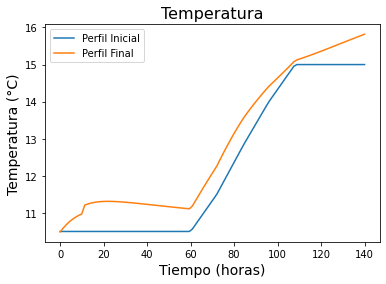

<Figure size 1440x1440 with 0 Axes>

In [7]:
import seaborn as sns
palette = sns.color_palette()

plt.title("Temperatura",fontsize=16)
plt.plot(a[0],a[1]-273.15, color=palette[0])
plt.plot(a[0],a[10]-273.15, color=palette[1])
plt.legend(['Perfil Inicial','Perfil Final'])
plt.xlabel("Tiempo (horas)",fontsize=14);
plt.ylabel("Temperatura (°C)",fontsize=14);
plt.figure(figsize=(20,20))

<Figure size 720x720 with 0 Axes>

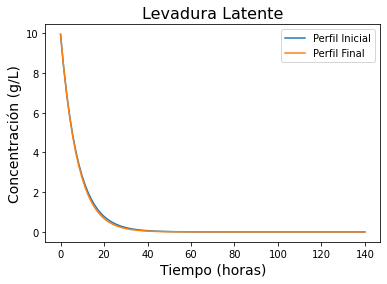

<Figure size 720x720 with 0 Axes>

In [8]:
plt.title("Levadura Latente",fontsize=16)
plt.plot(a[0],a[2], color=palette[0])
plt.plot(a[0],a[11], color=palette[1])
plt.legend(['Perfil Inicial','Perfil Final'])
plt.xlabel("Tiempo (horas)",fontsize=14);
plt.ylabel("Concentración (g/L)",fontsize=14);
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

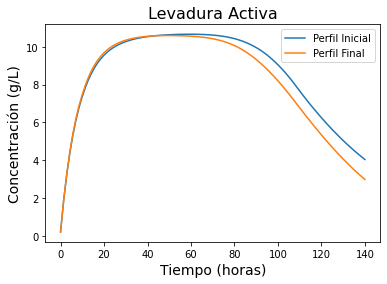

<Figure size 720x720 with 0 Axes>

In [9]:
plt.title("Levadura Activa",fontsize=16)
plt.plot(a[0],a[3], color=palette[0])
plt.plot(a[0],a[12], color=palette[1])
plt.legend(['Perfil Inicial','Perfil Final'])
plt.xlabel("Tiempo (horas)",fontsize=14);
plt.ylabel("Concentración (g/L)",fontsize=14);
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

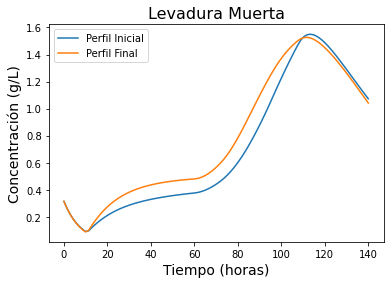

<Figure size 720x720 with 0 Axes>

In [10]:
plt.title("Levadura Muerta",fontsize=16)
plt.plot(a[0],a[4], color=palette[0])
plt.plot(a[0],a[13], color=palette[1])
plt.legend(['Perfil Inicial','Perfil Final'])
plt.xlabel("Tiempo (horas)",fontsize=14);
plt.ylabel("Concentración (g/L)",fontsize=14);
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

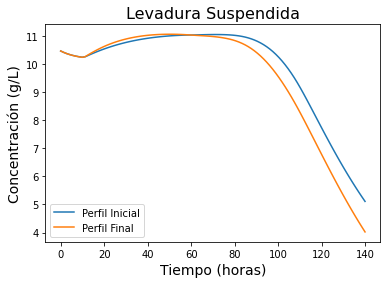

<Figure size 720x720 with 0 Axes>

In [11]:
plt.title("Levadura Suspendida",fontsize=16)
plt.plot(a[0],a[5], color=palette[0])
plt.plot(a[0],a[14], color=palette[1])
plt.legend(['Perfil Inicial','Perfil Final'])
plt.xlabel("Tiempo (horas)",fontsize=14);
plt.ylabel("Concentración (g/L)",fontsize=14);
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

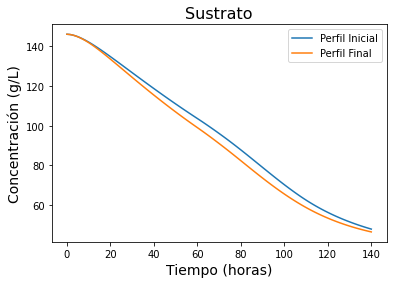

<Figure size 720x720 with 0 Axes>

In [12]:
plt.title("Sustrato",fontsize=16)
plt.plot(a[0],a[6], color=palette[0])
plt.plot(a[0],a[15], color=palette[1])
plt.legend(['Perfil Inicial','Perfil Final'])
plt.xlabel("Tiempo (horas)",fontsize=14);
plt.ylabel("Concentración (g/L)",fontsize=14);
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

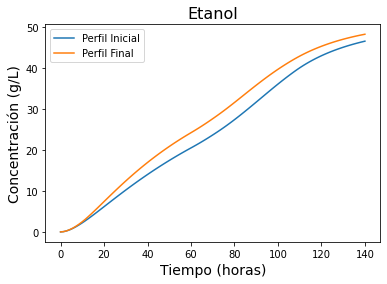

<Figure size 720x720 with 0 Axes>

In [13]:
plt.title("Etanol",fontsize=16)
plt.plot(a[0],a[7], color=palette[0])
plt.plot(a[0],a[16], color=palette[1])
plt.legend(['Perfil Inicial','Perfil Final'])
plt.xlabel("Tiempo (horas)",fontsize=14);
plt.ylabel("Concentración (g/L)",fontsize=14);
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

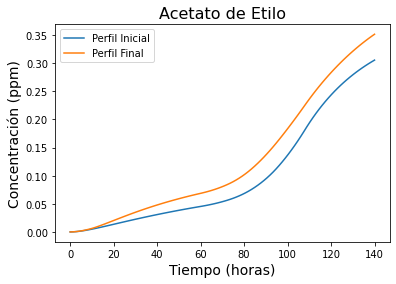

<Figure size 720x720 with 0 Axes>

In [14]:
plt.title("Acetato de Etilo",fontsize=16)
plt.plot(a[0],a[8], color=palette[0])
plt.plot(a[0],a[17], color=palette[1])
plt.legend(['Perfil Inicial','Perfil Final'])
plt.xlabel("Tiempo (horas)",fontsize=14);
plt.ylabel("Concentración (ppm)",fontsize=14);
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

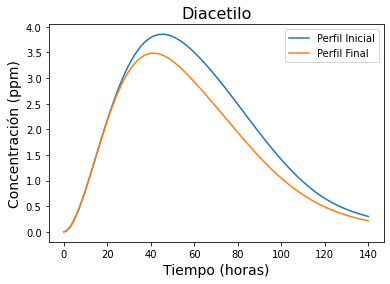

<Figure size 720x720 with 0 Axes>

In [15]:
plt.title("Diacetilo",fontsize=16)
plt.plot(a[0],a[9], color=palette[0])
plt.plot(a[0],a[18], color=palette[1])
plt.legend(['Perfil Inicial','Perfil Final'])
plt.xlabel("Tiempo (horas)",fontsize=14);
plt.ylabel("Concentración (ppm)",fontsize=14);
plt.figure(figsize=(10,10))

In [16]:
a[19]

1.7694825290369636

In [17]:
a[20]

-465.4456681148415

In [18]:
a[21]

-482.36978076601815